## Import Module and Load Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load the provided CSV file
file_path = '/content/datetime.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the data to understand its structure
data.head()

,Username,Profile,date,uptime,datetime
0,taFBL,HARIAN,2024-05-01,17:09:50,2024-05-01 17:09:50
1,tayHw,HARIAN,2024-05-02,23:17:47,2024-05-02 23:17:47
2,taUDL,HARIAN,2024-05-03,20:51:49,2024-05-03 20:51:49
3,taLWw,HARIAN,2024-05-04,23:29:21,2024-05-04 23:29:21
4,taE2U,HARIAN,2024-05-05,22:26:40,2024-05-05 22:26:40


## Data Preprocessing and EDA

In [3]:
# Convert 'datetime' column to datetime type
data['datetime'] = pd.to_datetime(data['datetime'])

# Extract the date and hour from the datetime
data['date'] = data['datetime'].dt.date
data['hour'] = data['datetime'].dt.hour

# Aggregate data to get the number of users per hour
user_count_per_hour = data.groupby(['date', 'hour']).size().reset_index(name='user_count')

# Pivot the data to have hours as columns and dates as rows
pivot_data = user_count_per_hour.pivot(index='date', columns='hour', values='user_count').fillna(0)

# Display the first few rows of the aggregated data
print(user_count_per_hour.head())

         date  hour  user_count
0  2024-05-01    10           1
1  2024-05-01    11           1
2  2024-05-01    12           2
3  2024-05-01    13           1
4  2024-05-01    16           1


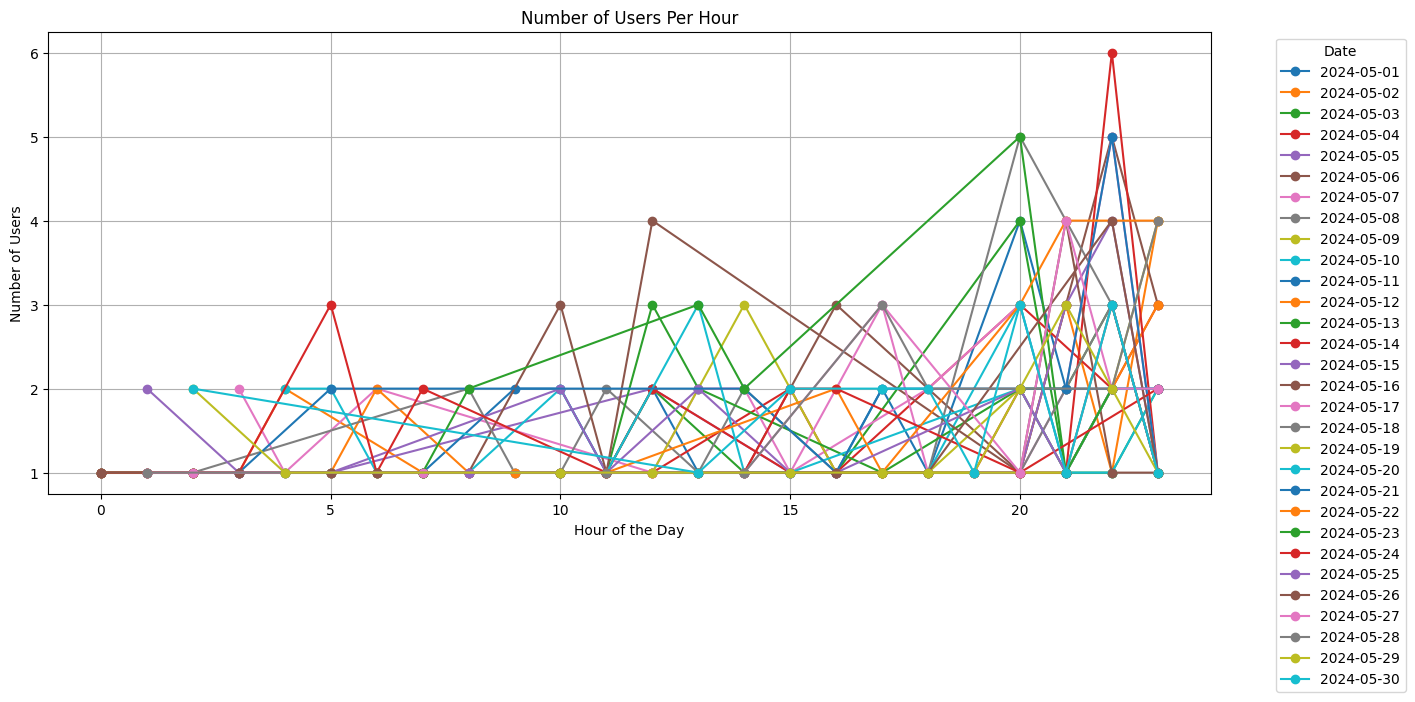

In [4]:
# Plot the number of users per hour
plt.figure(figsize=(15, 6))
for single_date in user_count_per_hour['date'].unique():
    daily_data = user_count_per_hour[user_count_per_hour['date'] == single_date]
    plt.plot(daily_data['hour'], daily_data['user_count'], marker='o', label=single_date)

plt.xlabel('Hour of the Day')
plt.ylabel('Number of Users')
plt.title('Number of Users Per Hour')
plt.legend(title='Date', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Time Series Forecasting

### Preparing the Data for Training

In [5]:
# Convert the pivoted data to a NumPy array
data_array = pivot_data.to_numpy()

# Split the data into training and testing sets
train_size = int(len(data_array) * 0.8)
train_data = data_array[:train_size]
test_data = data_array[train_size:]

# Normalize the data
mean = np.mean(train_data, axis=0)
std = np.std(train_data, axis=0)
train_data = (train_data - mean) / std
test_data = (test_data - mean) / std

### Prepare the Data

In [6]:
# Prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data)-time_step-1):
        X.append(data[i:(i+time_step), :])
        y.append(data[i + time_step, :])
    return np.array(X), np.array(y)

time_step = 1
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

### Building the LSTM Model

In [7]:
# Create and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(X_train.shape[2]))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

In [8]:
model.fit(X_train, y_train, batch_size=1, epochs=128, validation_data=(X_test, y_test))

Epoch 1/128
22/22 [==============================] - 4s 48ms/step - loss: 0.9941 - accuracy: 0.0455 - val_loss: 1.3546 - val_accuracy: 0.0000e+00
Epoch 2/128
22/22 [==============================] - 0s 5ms/step - loss: 0.9813 - accuracy: 0.0909 - val_loss: 1.3555 - val_accuracy: 0.0000e+00
Epoch 3/128
22/22 [==============================] - 0s 5ms/step - loss: 0.9708 - accuracy: 0.1818 - val_loss: 1.3526 - val_accuracy: 0.0000e+00
Epoch 4/128
22/22 [==============================] - 0s 5ms/step - loss: 0.9574 - accuracy: 0.2273 - val_loss: 1.3548 - val_accuracy: 0.0000e+00
Epoch 5/128
22/22 [==============================] - 0s 5ms/step - loss: 0.9381 - accuracy: 0.2727 - val_loss: 1.3634 - val_accuracy: 0.0000e+00
Epoch 6/128
22/22 [==============================] - 0s 4ms/step - loss: 0.9084 - accuracy: 0.2273 - val_loss: 1.3644 - val_accuracy: 0.0000e+00
Epoch 7/128
22/22 [==============================] - 0s 5ms/step - loss: 0.8716 - accuracy: 0.1818 - val_loss: 1.3748 - val_accur

In [9]:
# Save the model
model.save('lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# Predict on the test set
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 32ms/step


### Make Predictions

In [20]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Invert predictions to get actual values
train_predict = train_predict * std + mean
test_predict = test_predict * std + mean

# Predict for the next day (Tuesday)
last_day = data_array[-1].reshape(1, 1, data_array.shape[1])
next_day_predict = model.predict(last_day)
next_day_predict = next_day_predict * std + mean

next_day_predict

1/1 [==============================] - 0s 19ms/step


array([[ 0.35202798,  0.30656207,  0.6340104 ,  0.3700104 ,  0.30928017,
         0.20942684, -0.02915092,  0.89687896,  0.7429223 ,  0.66526726,
         1.3891761 ,  0.59711682,  0.97382807,  0.40036257,  0.37602124,
         0.64117861,  0.12533158,  0.19532803,  0.28118896,  0.56317602,
         1.66712628,  1.79152371,  1.58739055,  1.14932869]])

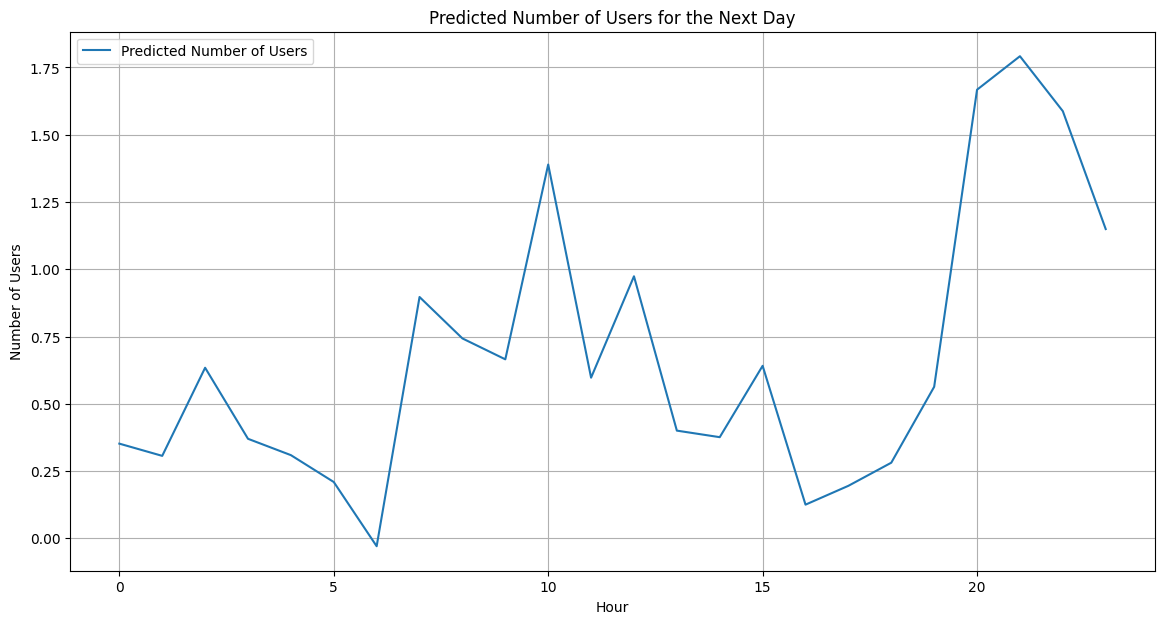

In [18]:
# Plot the prediction results for the next day
plt.figure(figsize=(14, 7))
plt.plot(range(24), next_day_predict[0], label='Predicted Number of Users')
plt.title('Predicted Number of Users for the Next Day')
plt.xlabel('Hour')
plt.ylabel('Number of Users')
plt.legend()
plt.grid(True)
plt.show()